# **Nhúng thư viện**

In [12]:
!pip install np_utils
!pip install --upgrade tensorflow

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from keras.utils import np_utils

import itertools

import cv2
from PIL import Image

import pickle
import tempfile
import keras.models

# **Kết nối google drive**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
pip install -q tensorflow-model-optimization

In [16]:
import tensorflow_model_optimization as tfmot

# Nạp dữ liệu từ google drive bằng cách mới

In [17]:
train_data_dir = "/content/drive/MyDrive/Master_MLR/dataset/train/train"
val_data_dir = "/content/drive/MyDrive/Master_MLR/dataset/val/val"
test_data_dir = "/content/drive/MyDrive/Master_MLR//dataset/test/test"

pic_width = 384
pic_height = 288

train_val_test = (train_data_dir, val_data_dir, test_data_dir)

# data_gen_args = dict(
#                 zoom_range=0.1,
#                 width_shift_range=0.1,
#                 height_shift_range=0.1,
#                 horizontal_flip=True
#             )

# train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
# # train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)
# train_generator = train_gen.flow_from_directory(
#     train_data_dir,
#     target_size=(pic_height, pic_width),
#     batch_size=16
# )

# **Begin tuning model**

In [18]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        # self.input_shape = data[0][0].shape
        self.input_shape = (pic_height, pic_width, 3)

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers

        self.classes = classes

        # self.trainX = data[0]
        # self.trainY = data[1]
        # self.valX = data[2]
        # self.valY = data[3]
        # self.testX = data[4]
        # self.testY = data[5]

        # Thử sử dụng đường dẫn để giảm lượng ram sử dụng
        self.train = data[0]
        self.val = data[1]
        self.test = data[2]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.val_generator = self.create_val_generator() #newly added code
        self.test_generator = self.create_test_generator() #newly added code
        self.X_test, self.y_test = self.getXnYTest() #newly added code
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        nn = None

        if self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == "ResNet50V2":
            nn = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        return nn

    def run(self):
        self.fine_tune()

    def build(self):

        # model = tf.keras.models.Sequential()
        # model.add(self.nn)
        # # model.add(tf.keras.layers.Flatten())
        # # model.add(tf.keras.layers.Dropout(0.25))
        # model.add(tf.keras.layers.GlobalAveragePooling2D())

        # z1 = tf.keras.layers.Dense(units=512)(model)
        # # for layer in self.hidden_layers:
        # #     model.add(tf.keras.layers.Dense(layer, activation='relu'))
        # #     # model.add(tf.keras.layers.BatchNormalization())
        # #     # model.add(tf.keras.layers.Dropout(0.4))

        # # Code that I add in for testing. This should produce a similar model to TestFixR

        # # model.add(tf.keras.layers.Dense(1024, activation="relu"))
        # # model.add(tf.keras.layers.Dense(512, activation="relu"))

        # model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))

        # print (model.summary())

        # Using the functional api
        # inputs = tf.keras.Input(shape=self.input_shape)
        # # base_model = self.nn(inputs, training=False)
        # # base_model = self.nn
        # global_avg_pool_2d = tf.keras.layers.GlobalAveragePooling2D()(self.nn.output)

        inputs = tf.keras.Input(shape=self.input_shape)
        base_model = self.nn(inputs, training=False)
        global_avg_pool_2d = tf.keras.layers.GlobalAveragePooling2D()(base_model)

        # Adding first dense layer after global average pooling
        z1 = tf.keras.layers.Dense(1024)(global_avg_pool_2d)  #z1
        batch_norm1 = tf.keras.layers.BatchNormalization()(z1) #bn1
        a1 = tf.keras.layers.Activation('relu')(batch_norm1) #a1
        da1 = tf.keras.layers.Dropout(0.5)(a1) #Adding dropout

        # Adding second dense layer
        z2 = tf.keras.layers.Dense(1024)(da1) #z2
        batch_norm2 = tf.keras.layers.BatchNormalization()(z2) #bn2
        a2 = tf.keras.layers.Activation('relu')(batch_norm2) #a2
        a2 = tf.keras.layers.Dropout(0.5)(a2) #Adding dropout

        # Adding third dense layer
        z3 = tf.keras.layers.Dense(1024)(a2) #z3
        batch_norm3 = tf.keras.layers.BatchNormalization()(z3) #bn3

        # Adding in the shortcut value, and passing it through a relu
        X = tf.keras.layers.Add()([a1, batch_norm3]) #Adding a1 to z3
        X = tf.keras.layers.Activation('relu')(X)
        a3 = X #shortcut to activation of layer 3
        X = tf.keras.layers.Dropout(0.5)(X)

        # Adding fourth dense layer
        X = tf.keras.layers.Dense(512)(X)
        X = tf.keras.layers.BatchNormalization()(X)
        X = tf.keras.layers.Activation('relu')(X)
        a4 = X #Shortcut value
        X = tf.keras.layers.Dropout(0.5)(X)

        # Adding fifth dense layer
        X = tf.keras.layers.Dense(512)(X)
        X = tf.keras.layers.BatchNormalization()(X)

        # EXPERIMENTAL! Adding a3 (1024) to fifth dense layer (512)
        # Modifying shape
        a3 = tf.keras.layers.Dense(512)(a3)
        a3 = tf.keras.layers.BatchNormalization()(a3)
        X = tf.keras.layers.Add()([a3, X])

        X = tf.keras.layers.Activation('relu')(X)
        X = tf.keras.layers.Dropout(0.5)(X)

        # Adding sixth dense layer
        # X = tf.keras.layers.Dense(512)(X)
        # X = tf.keras.layers.BatchNormalization()(X)

        # # Adding in the shortcut value a4
        # X = tf.keras.layers.Add()([a4, X])
        # X = tf.keras.layers.Activation('relu')(X)
        # X = tf.keras.layers.Dropout(0.5)(X)

        outputs = tf.keras.layers.Dense(self.classes, activation='softmax')(X)

        # Creating the model
        model = tf.keras.Model(inputs, outputs)

        # Implement quantize aware training
        # quantize_model = tfmot.quantization.keras.quantize_model

        # q_aware_model = quantize_model(model)

        print (model.summary())

        return model

    def load_weights(self, name):
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                zoom_range=0.1,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                preprocessing_function=preprocess_input
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        # train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)
        train_generator = train_gen.flow_from_directory(
            self.train,
            target_size=(pic_height, pic_width),
            batch_size=self.BATCH_SIZE,
            seed=42
        )

        return train_generator

    def create_val_generator(self):
        data_gen_args = dict(
                zoom_range=0.1,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                preprocessing_function=preprocess_input
            )

        val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        val_generator = val_gen.flow_from_directory(self.val, target_size=(pic_height, pic_width), batch_size=16, seed=42)

        return val_generator

    def create_test_generator(self):
        test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_gen.flow_from_directory(self.test, target_size=(pic_height, pic_width), batch_size=1, seed=42)

        return test_generator


    def fine_tune(self):

        # numTrainingSamples = self.trainX.shape[0]
        # numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")



        # self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
        self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy']) # suggested by someone on Stackoverflow
        #link https://stackoverflow.com/questions/57595780/logits-and-labels-must-have-the-same-first-dimension-got-logits-shape-3662-5

        best_weights_ph1 = self.base_arch + "_ph1_weights.keras"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        # history = self.model.fit(
        #     x_train, y_train,
        #     steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
        #     epochs=self.EPOCHS,
        #     validation_data=(self.valX, self.valY),
        #     validation_steps=numValidationSamples // self.BATCH_SIZE,
        #     callbacks=[checkpoint])
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=len(self.train_generator) // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=self.val_generator,
            # validation_steps=len(self.val_generator) // self.BATCH_SIZE,
            callbacks=[checkpoint]
            )
        print(history.history.keys())
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        self.predict()

        self.plot_acc(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')

        self.calculate_metrics()
        self.turn_into_a_pickle()
#################################################################################################################
        print ("\nPhase B  - Fine Tune all Layers \n")
        self.nn.trainable = True

        # self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])
        self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy']) # suggested by someone on Stackoverflow
        #link https://stackoverflow.com/questions/57595780/logits-and-labels-must-have-the-same-first-dimension-got-logits-shape-3662-5

        best_weights_ph2 = self.base_arch + "_ph2_weights.keras"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        history = self.model.fit(
            self.train_generator,

            steps_per_epoch=len(self.train_generator) // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=self.val_generator,
            # validation_steps=len(self.val_generator) // self.BATCH_SIZE,
            callbacks=[checkpoint]
            )
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        y_pred=self.predict_score()

        self.plot_acc(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')

        self.calculate_metrics()
        return y_pred

    def predict(self):

        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.test_generator, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.X_test, batch_size=self.BATCH_SIZE)
        print('Done')

    def predict_score(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.X_test, batch_size=self.BATCH_SIZE)
        print('Done')
        return self.predictions

    def plot_loss(self, model_history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss", )
        plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
        plt.title("Training Loss - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def plot_acc(self, model_history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc")
        plt.title("Training Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def getXnYTest(self):
        #get testX from test_generator
        self.test_generator.reset()
        X_test, y_test = next(self.test_generator)
        for i in tqdm(range(int(len(self.test_generator)/1)-1)): #1st batch is already fetched before the for loop.
          img, label = next(self.test_generator)
          X_test = np.append(X_test, img, axis=0 )
          y_test = np.append(y_test, label, axis=0)

        return (X_test, y_test)

    def turn_into_a_pickle(self):
        with open('fitted_model.pickle', 'wb') as modelFile:
            pickle.dump(self.model, modelFile)

    def calculate_metrics(self):

        #get testX from test_generator
        # self.test_generator.reset()
        # X_test, y_test = next(self.test_generator)
        # for i in tqdm(range(int(len(self.test_generator)/1)-1)): #1st batch is already fetched before the for loop.
        #   img, label = next(self.test_generator)
        #   X_test = np.append(X_test, img, axis=0 )
        #   y_test = np.append(y_test, label, axis=0)

        # predict probabilities for test set
        probs = self.model.predict(self.X_test, verbose=0)
        # predict crisp classes for test set
        classes = np.argmax(probs, axis=1)

        # y_true = self.testY
        # y_true = self.y_test
        y_pred = classes
        #I needed to modify these so it would work.
        y_true = np.argmax(self.y_test, axis=1)

        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_true, y_pred)
        print("ACC:       {}".format(accuracy))

        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, average='weighted')
        print("Precision: {}".format(precision))

        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, average='weighted')
        print("Recall:    {}".format(recall))

        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print("F1:        {}".format(f1))

    def saveModel(self, model_name):
        tf.keras.models.save_model(self.model, model_name, include_optimizer=False)

    def model_summary(self):
        print(self.model.summary())


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
HIDDEN_LAYERS = [1028]
CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 50

In [ ]:
NET = 'ResNet50V2'
model1 = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 288, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 9, 12, 2048)    │     23,564,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50v2[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1024)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024)           │          4,096 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1024)           │          4,096 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1024)           │              0 │ activation[0][0],      │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 1024)           │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 29,093,890 (110.98 MB)

 Trainable params: 5,519,874 (21.06 MB)

 Non-trainable params: 23,574,016 (89.93 MB)

None
Found 19200 images belonging to 2 classes.
Found 3381 images belonging to 2 classes.
Found 3396 images belonging to 2 classes.


100%|██████████| 3395/3395 [49:13<00:00,  1.15it/s]


In [ ]:
# Plotting model
# tf.keras.utils.plot_model(model1.model, "Cheat_Detect_Model.png", show_shapes=True)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Phase A - Training Fully Connected Layers

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5405 - loss: 1.2280
Epoch 1: val_loss improved from inf to 0.77907, saving model to ResNet50V2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1217s 16s/step - accuracy: 0.5405 - loss: 1.2281 - val_accuracy: 0.5670 - val_loss: 0.7791
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5528 - loss: 1.1622
Epoch 2: val_loss improved from 0.77907 to 0.61942, saving model to ResNet50V2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 361s 5s/step - accuracy: 0.5527 - loss: 1.1624 - val_accuracy: 0.6844 - val_loss: 0.6194
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5607 - loss: 1.1516
Epoch 3: val_loss improved from 0.61942 to 0.61848, saving model to ResNet50V2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.5607 - loss: 1.1515 - val_accuracy: 0.6392 - val_loss: 0.6185
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5378 - 

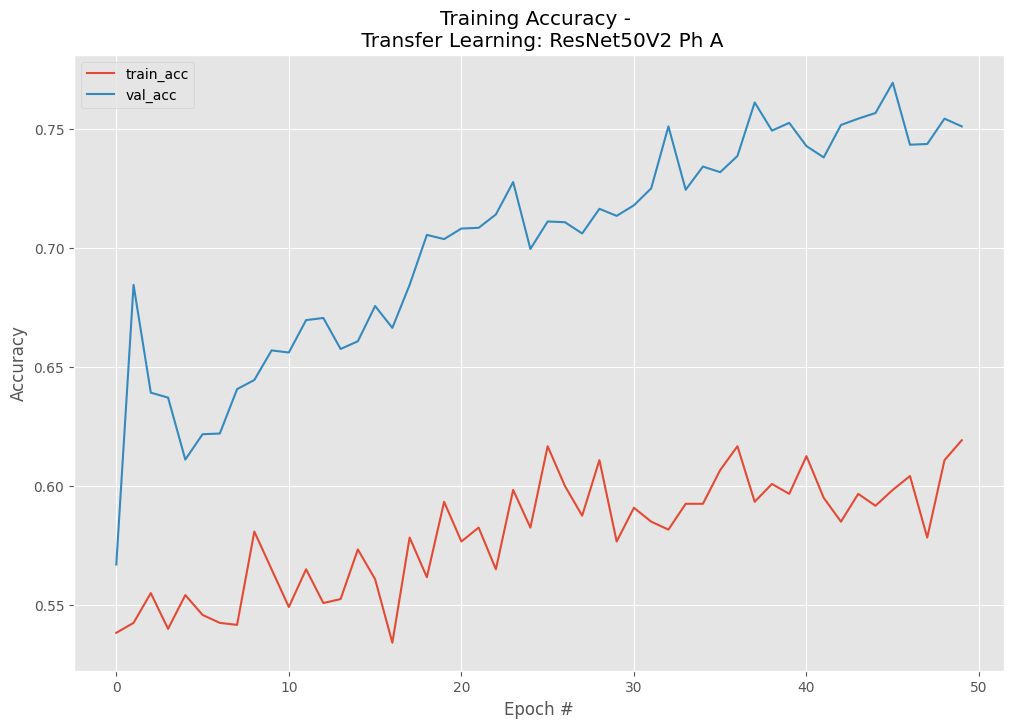

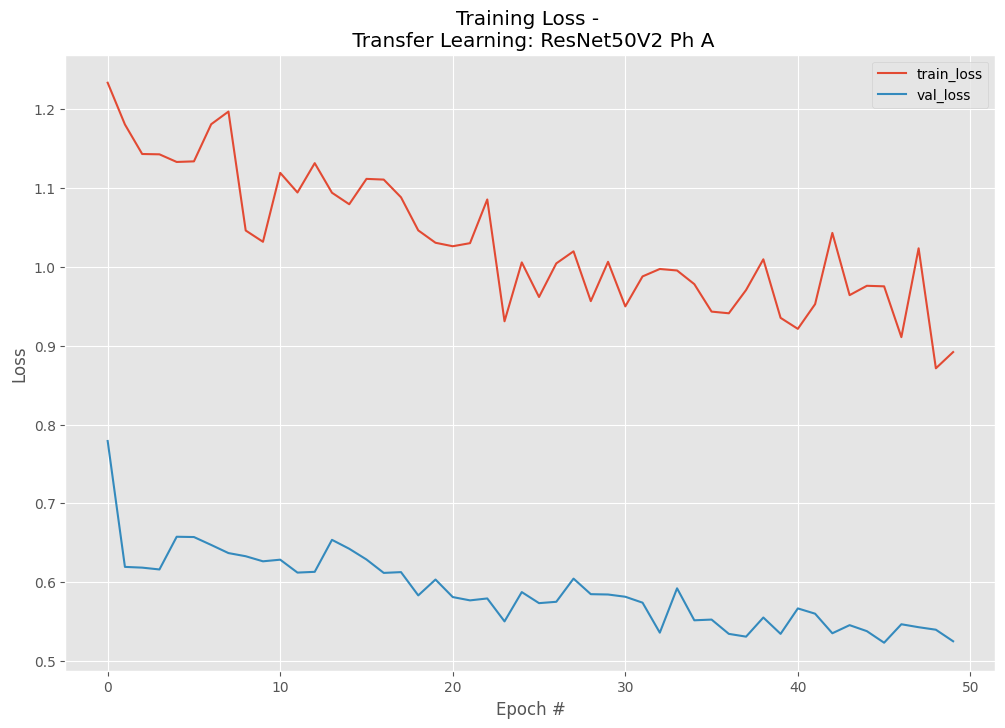

ACC:       0.7794464075382803
Precision: 0.782392869913186
Recall:    0.7794464075382803
F1:        0.7806620864687206

Phase B  - Fine Tune all Layers 

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5615 - loss: 0.9807
Epoch 1: val_loss improved from inf to 1.40813, saving model to ResNet50V2_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5615 - loss: 0.9809 - val_accuracy: 0.6513 - val_loss: 1.4081
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6245 - loss: 0.8218
Epoch 2: val_loss improved from 1.40813 to 1.20631, saving model to ResNet50V2_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6249 - loss: 0.8209 - val_accuracy: 0.6513 - val_loss: 1.2063
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7430 - loss: 0.5973
Epoch 3: val_loss improved from 1.20631 to 0.94970, saving model to ResNet50V2_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7430 - loss: 0.

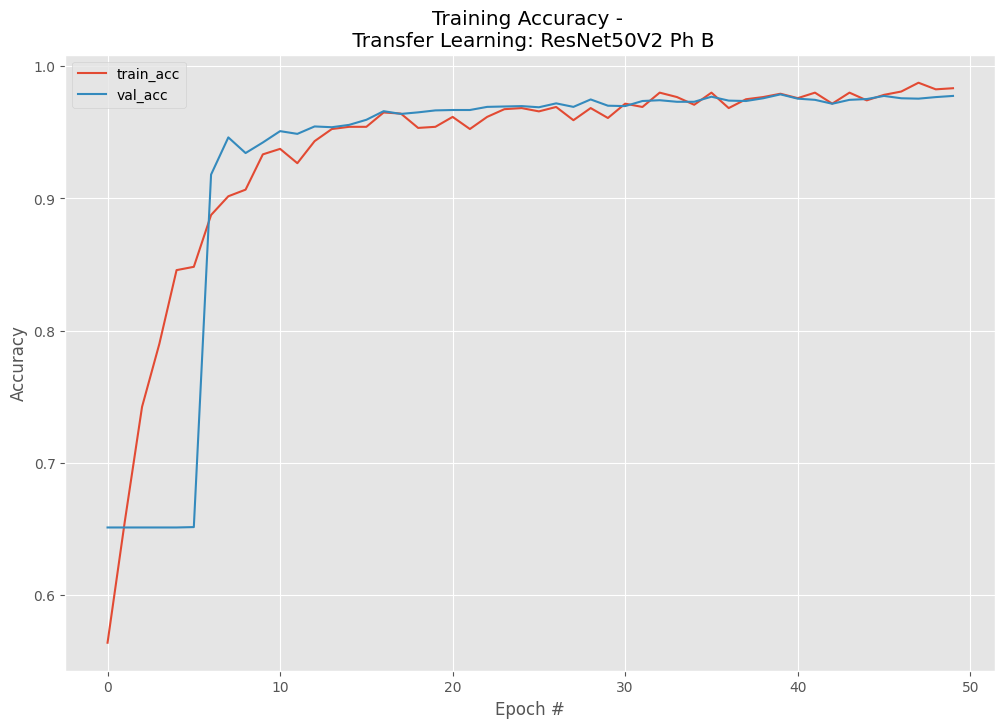

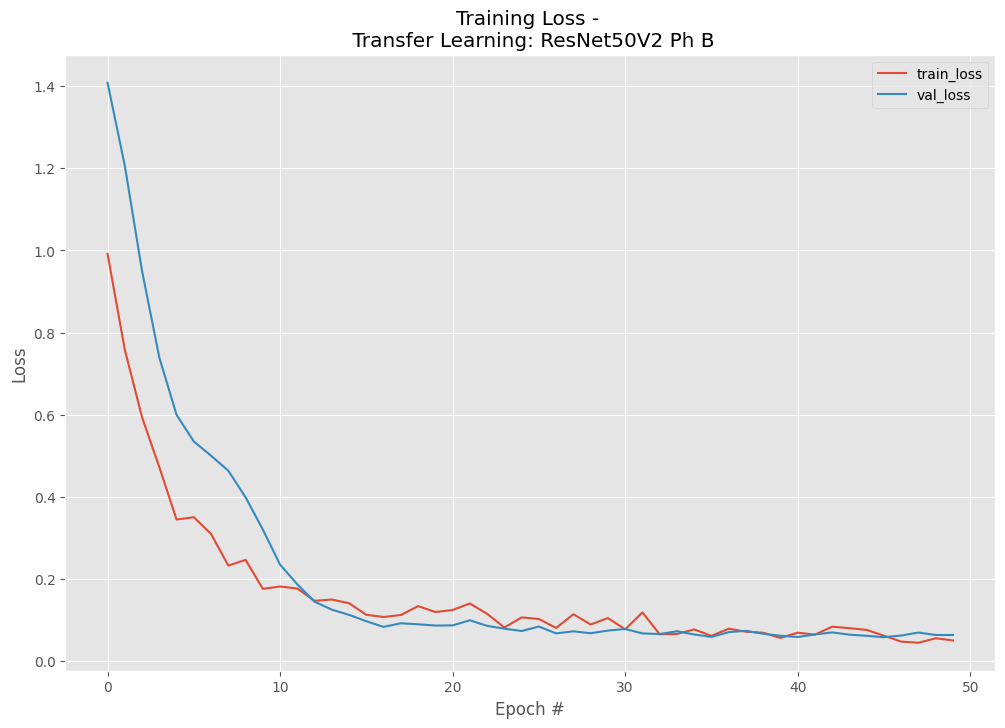

ACC:       0.9782096584216725
Precision: 0.9782294910518485
Recall:    0.9782096584216725
F1:        0.9782180918717148

Predicting test set classes.
Test set score: [0.06087573245167732, 0.9782096743583679]
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step
Done


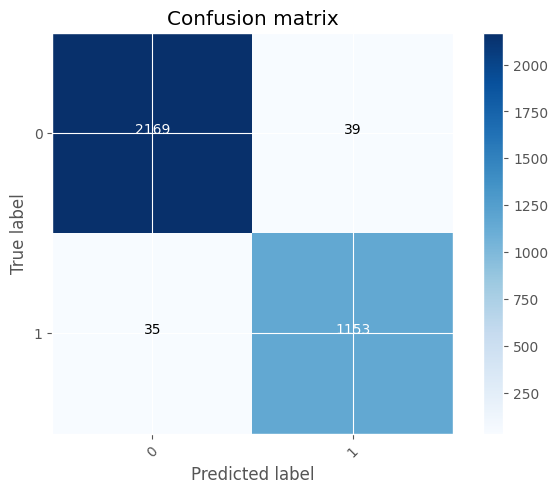

In [ ]:
model1.run()
model1.predict()
################################################################################
Y_pred = model1.predictions
Y_pred_classes = np.argmax(Y_pred,axis = 1)
confusion_mtx = confusion_matrix(np.argmax(model1.y_test, axis=1), Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))


In [ ]:
model1.saveModel('ResNet50V2.keras')


Phase A - Training Fully Connected Layers

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9797 - loss: 0.0663
Epoch 1: val_loss improved from inf to 0.07529, saving model to ResNet50V2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9798 - loss: 0.0661 - val_accuracy: 0.9734 - val_loss: 0.0753
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9746 - loss: 0.0646
Epoch 2: val_loss improved from 0.07529 to 0.05702, saving model to ResNet50V2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9746 - loss: 0.0647 - val_accuracy: 0.9808 - val_loss: 0.0570
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9901 - loss: 0.0283
Epoch 3: val_loss did not improve from 0.05702
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9900 - loss: 0.0284 - val_accuracy: 0.9775 - val_loss: 0.0597
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9839 - loss: 0.0598
Epoch 4: val_loss did not i

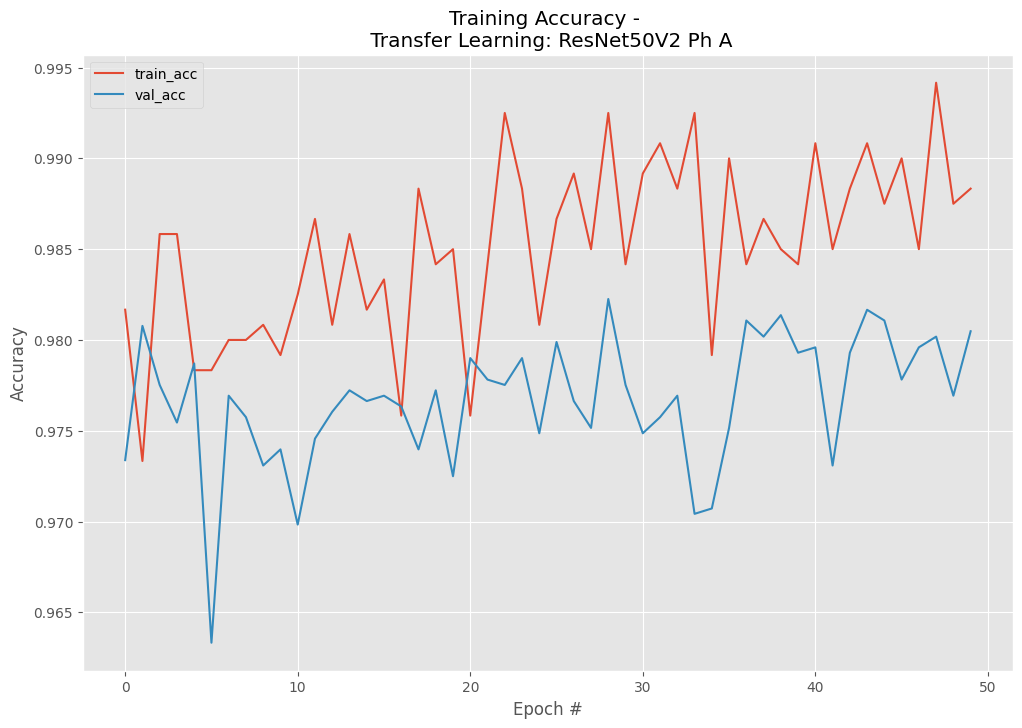

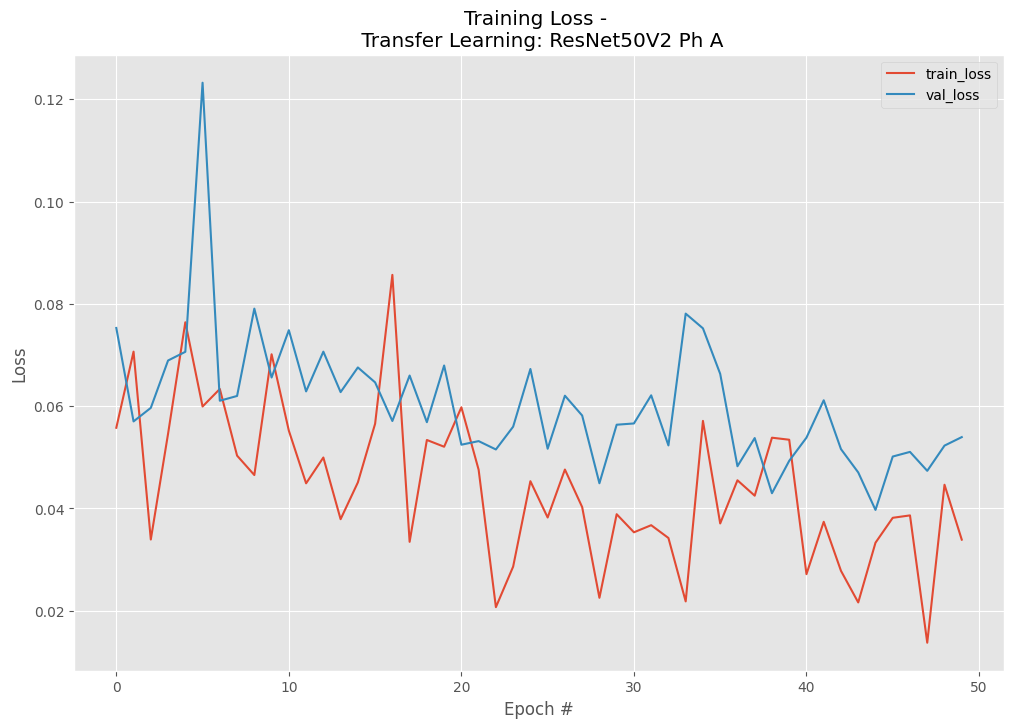

ACC:       0.9787985865724381
Precision: 0.9790008123633006
Recall:    0.9787985865724381
F1:        0.9788466662804843

Phase B  - Fine Tune all Layers 

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9968 - loss: 0.0105
Epoch 1: val_loss improved from inf to 0.04973, saving model to ResNet50V2_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9967 - loss: 0.0107 - val_accuracy: 0.9802 - val_loss: 0.0497
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9954 - loss: 0.0169
Epoch 2: val_loss improved from 0.04973 to 0.04240, saving model to ResNet50V2_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9954 - loss: 0.0170 - val_accuracy: 0.9834 - val_loss: 0.0424
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9901 - loss: 0.0614
Epoch 3: val_loss did not improve from 0.04240
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9901 - loss: 0.0610 - val_accuracy: 0.9784 - val_loss: 0.0599
Ep

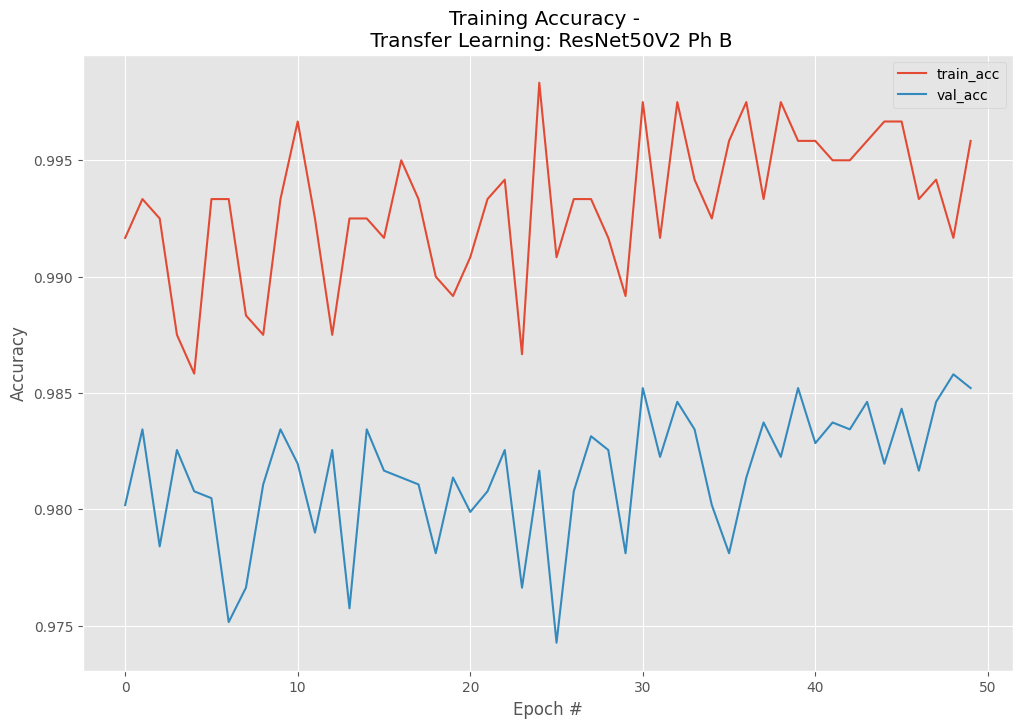

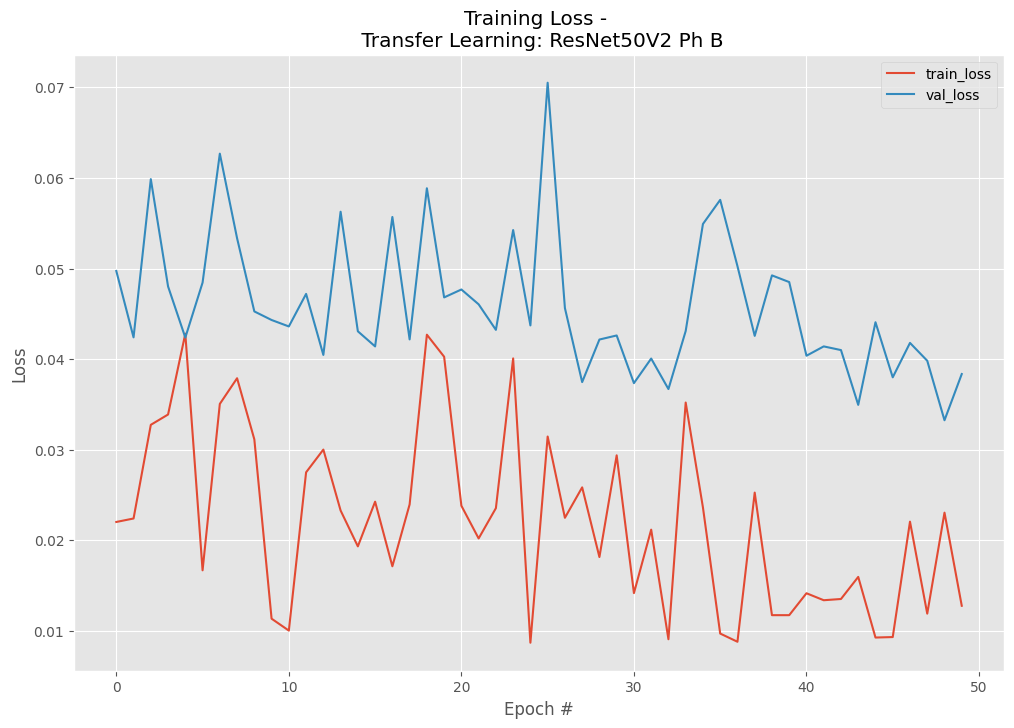

ACC:       0.9826266195524146
Precision: 0.982611950014666
Recall:    0.9826266195524146
F1:        0.9826146997017742

Predicting test set classes.
Test set score: [0.048913631588220596, 0.9826266169548035]
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step
Done


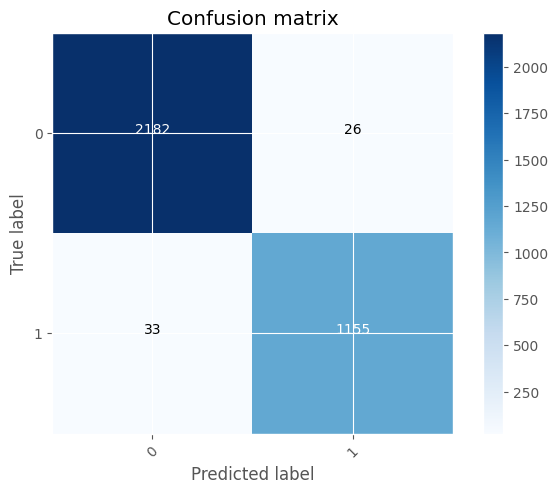

In [ ]:
NET = 'Xception'

model1.run()
model1.predict()
################################################################################
Y_pred = model1.predictions
Y_pred_classes = np.argmax(Y_pred,axis = 1)
confusion_mtx = confusion_matrix(np.argmax(model1.y_test, axis=1), Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
model1.saveModel('Xception.keras')

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 288, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 9, 12, 512)     │     20,024,384 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │        525,312 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1024)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024)           │          4,096 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1024)           │          4,096 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1024)           │              0 │ activation[0][0],      │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 1024)           │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 23,980,610 (91.48 MB)

 Trainable params: 3,947,010 (15.06 MB)

 Non-trainable params: 20,033,600 (76.42 MB)

None
Found 19200 images belonging to 2 classes.
Found 3381 images belonging to 2 classes.
Found 3396 images belonging to 2 classes.


100%|██████████| 3395/3395 [59:39<00:00,  1.05s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Phase A - Training Fully Connected Layers

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5114 - loss: 1.1812 
Epoch 1: val_loss improved from inf to 0.66952, saving model to VGG19_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3497s 47s/step - accuracy: 0.5114 - loss: 1.1814 - val_accuracy: 0.6046 - val_loss: 0.6695
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5363 - loss: 1.1736 
Epoch 2: val_loss improved from 0.66952 to 0.56071, saving model to VGG19_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 903s 12s/step - accuracy: 0.5365 - loss: 1.1729 - val_accuracy: 0.7110 - val_loss: 0.5607
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5786 - loss: 1.0401 
Epoch 3: val_loss improved from 0.56071 to 0.51038, saving model to VGG19_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 834s 11s/step - accuracy: 0.5785 - loss: 1.0403 - val_accuracy: 0.7589 - val_loss: 0.5104
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5799 - loss: 1

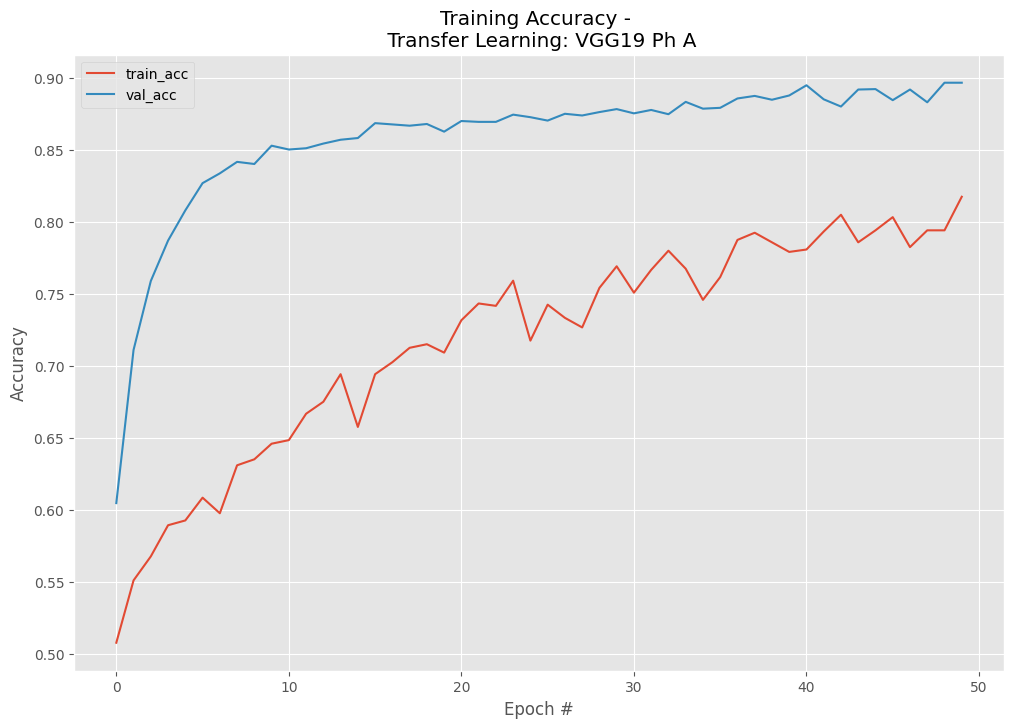

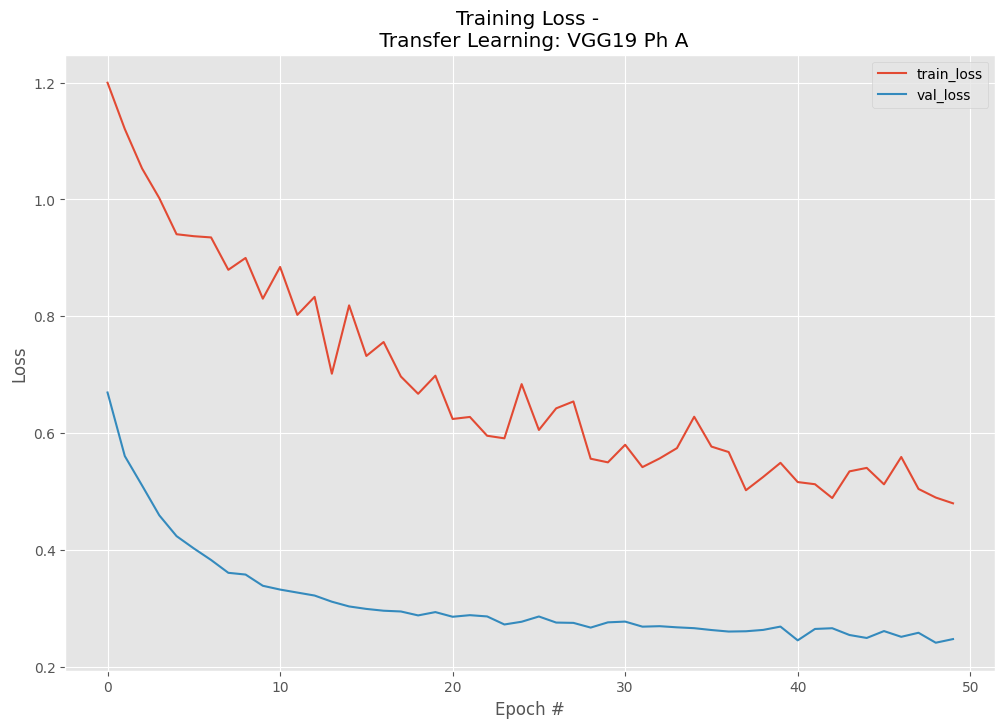

ACC:       0.8825088339222615
Precision: 0.8903850892676403
Recall:    0.8825088339222615
F1:        0.8841006462374649

Phase B  - Fine Tune all Layers 

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.8455 - loss: 0.3767
Epoch 1: val_loss improved from inf to 0.22790, saving model to VGG19_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8459 - loss: 0.3759 - val_accuracy: 0.9269 - val_loss: 0.2279
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.9031 - loss: 0.2873
Epoch 2: val_loss improved from 0.22790 to 0.18403, saving model to VGG19_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9033 - loss: 0.2865 - val_accuracy: 0.9494 - val_loss: 0.1840
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9441 - loss: 0.1587
Epoch 3: val_loss did not improve from 0.18403
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9442 - loss: 0.1585 - val_accuracy: 0.9275 - val_loss: 0.2816
Epoch 4/50
7

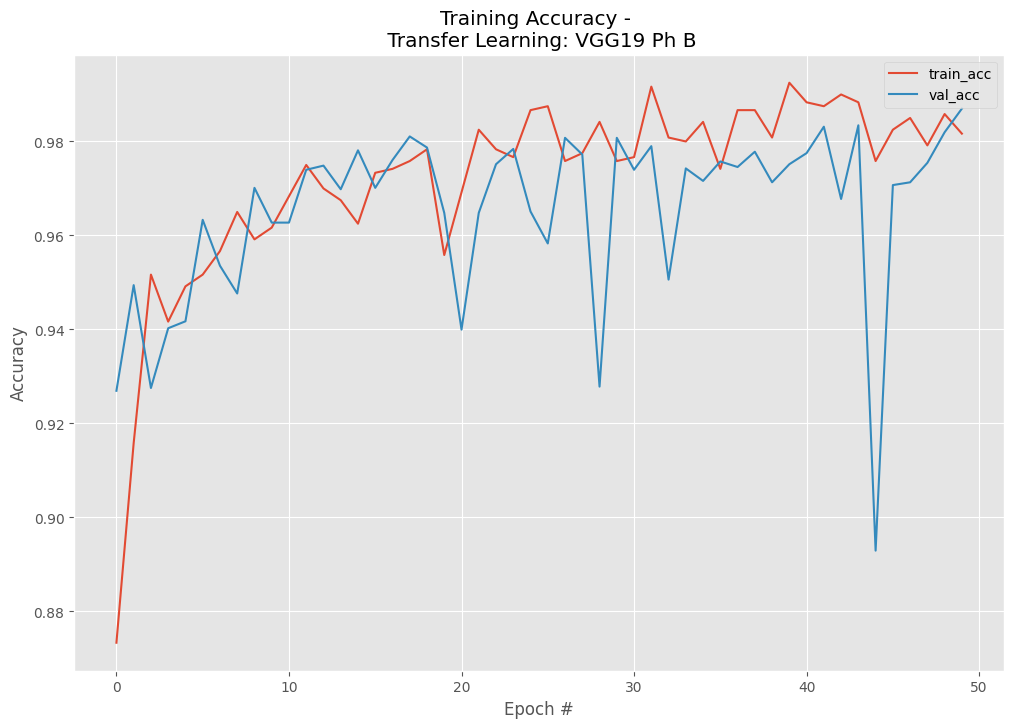

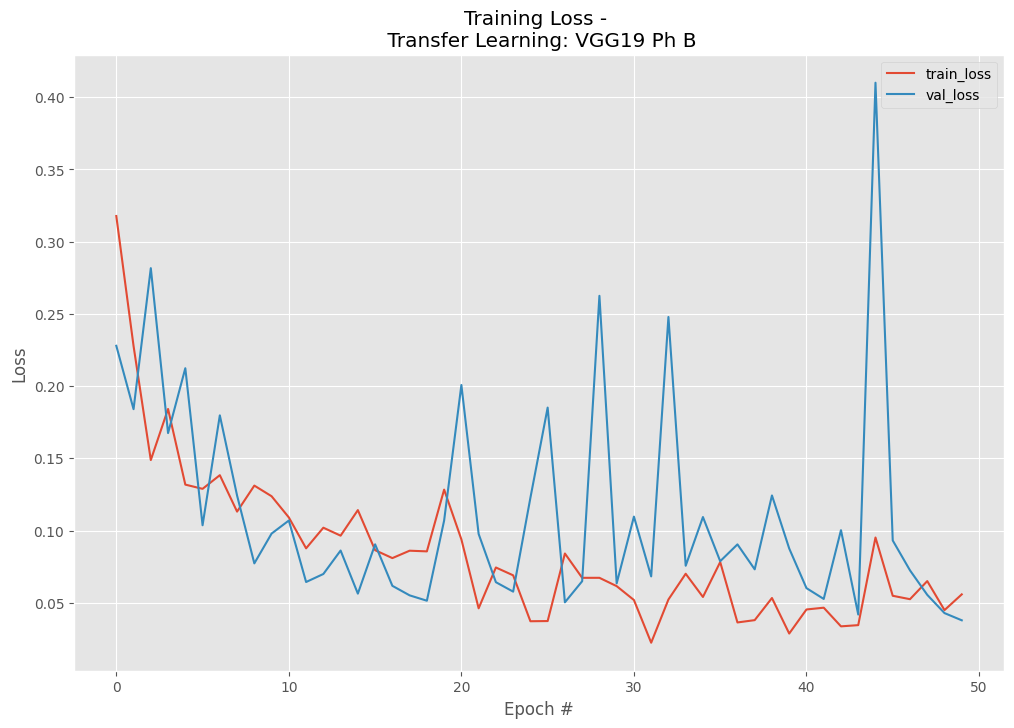

ACC:       0.9838044758539458
Precision: 0.9838247917070398
Recall:    0.9838044758539458
F1:        0.983812301759481

Predicting test set classes.
Test set score: [0.051950469613075256, 0.98380446434021]
213/213 ━━━━━━━━━━━━━━━━━━━━ 55s 259ms/step
Done


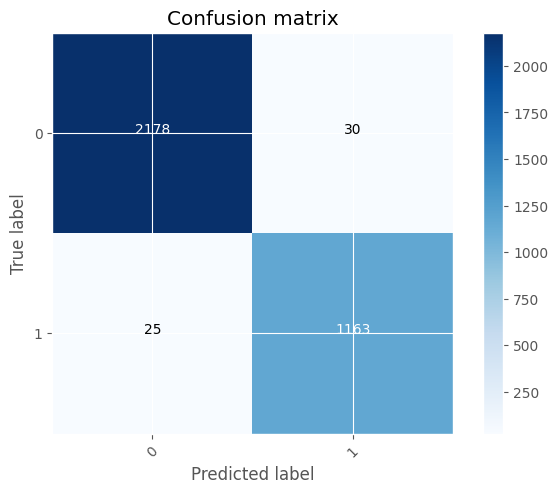

In [ ]:
NET = 'VGG19'

model1 = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model1.run()
################################################################################
model1.predict()
Y_pred = model1.predictions
Y_pred_classes = np.argmax(Y_pred,axis = 1)
confusion_mtx = confusion_matrix(np.argmax(model1.y_test, axis=1), Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
model1.saveModel('VGG19.keras')

<ipython-input-8-335afbd3c527>:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 288, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 9, 12, 1280)    │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      1,311,744 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1024)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024)           │          4,096 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      1,049,600 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 1024)           │          4,096 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1024)           │              0 │ activation[0][0],      │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 1024)           │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ activation_2[0][0]     │
├──────────────────────

 Total params: 7,000,642 (26.71 MB)

 Trainable params: 4,733,442 (18.06 MB)

 Non-trainable params: 2,267,200 (8.65 MB)

None
Found 19200 images belonging to 2 classes.
Found 3381 images belonging to 2 classes.
Found 3396 images belonging to 2 classes.


100%|██████████| 3395/3395 [58:04<00:00,  1.03s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Phase A - Training Fully Connected Layers

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5064 - loss: 1.2913 
Epoch 1: val_loss improved from inf to 0.83392, saving model to MobileNetV2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3050s 41s/step - accuracy: 0.5063 - loss: 1.2917 - val_accuracy: 0.3869 - val_loss: 0.8339
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5177 - loss: 1.1868
Epoch 2: val_loss improved from 0.83392 to 0.79058, saving model to MobileNetV2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 793s 11s/step - accuracy: 0.5178 - loss: 1.1866 - val_accuracy: 0.4644 - val_loss: 0.7906
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5417 - loss: 1.1518
Epoch 3: val_loss improved from 0.79058 to 0.73172, saving model to MobileNetV2_ph1_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 731s 10s/step - accuracy: 0.5417 - loss: 1.1512 - val_accuracy: 0.5368 - val_loss: 0.7317
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0

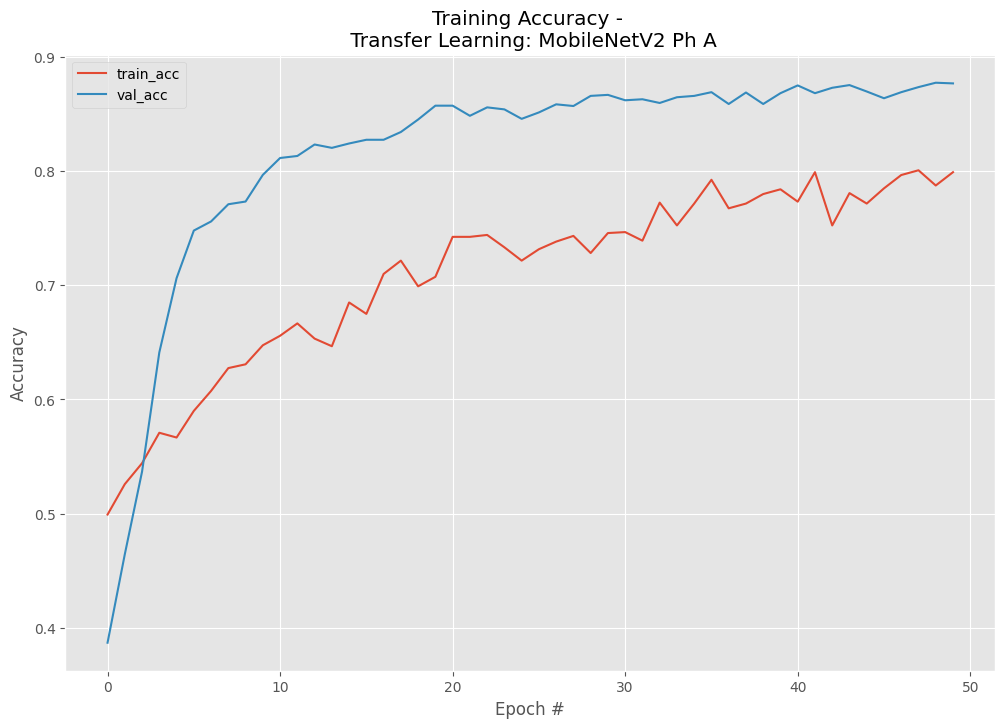

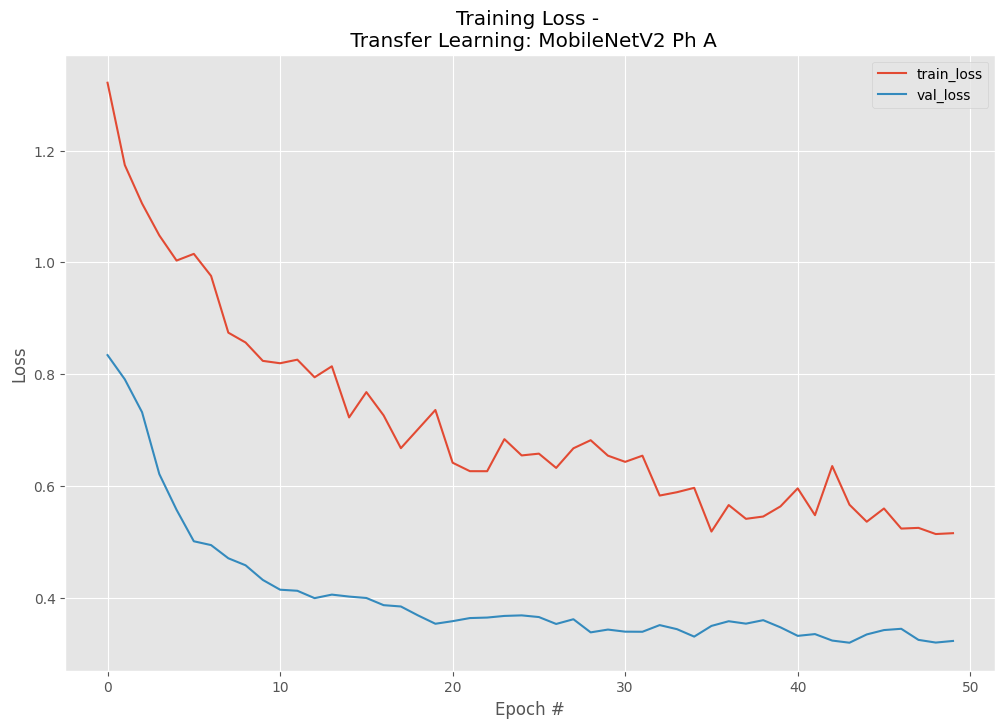

ACC:       0.8754416961130742
Precision: 0.8891572085280934
Recall:    0.8754416961130742
F1:        0.87761649422486

Phase B  - Fine Tune all Layers 

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.6337 - loss: 0.9280
Epoch 1: val_loss improved from inf to 0.51322, saving model to MobileNetV2_ph2_weights.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6337 - loss: 0.9283 - val_accuracy: 0.7791 - val_loss: 0.5132
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.7212 - loss: 0.6520
Epoch 2: val_loss did not improve from 0.51322
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7212 - loss: 0.6520 - val_accuracy: 0.7456 - val_loss: 0.5611
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.7661 - loss: 0.5668
Epoch 3: val_loss did not improve from 0.51322
75/75 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7661 - loss: 0.5668 - val_accuracy: 0.7158 - val_loss: 0.6328
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step -

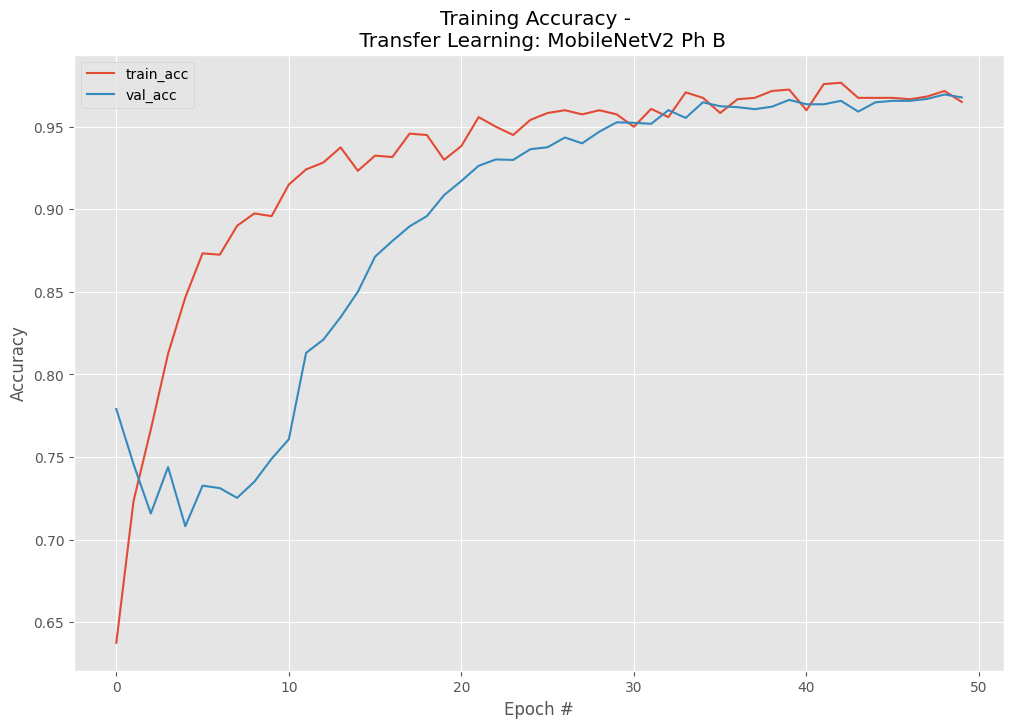

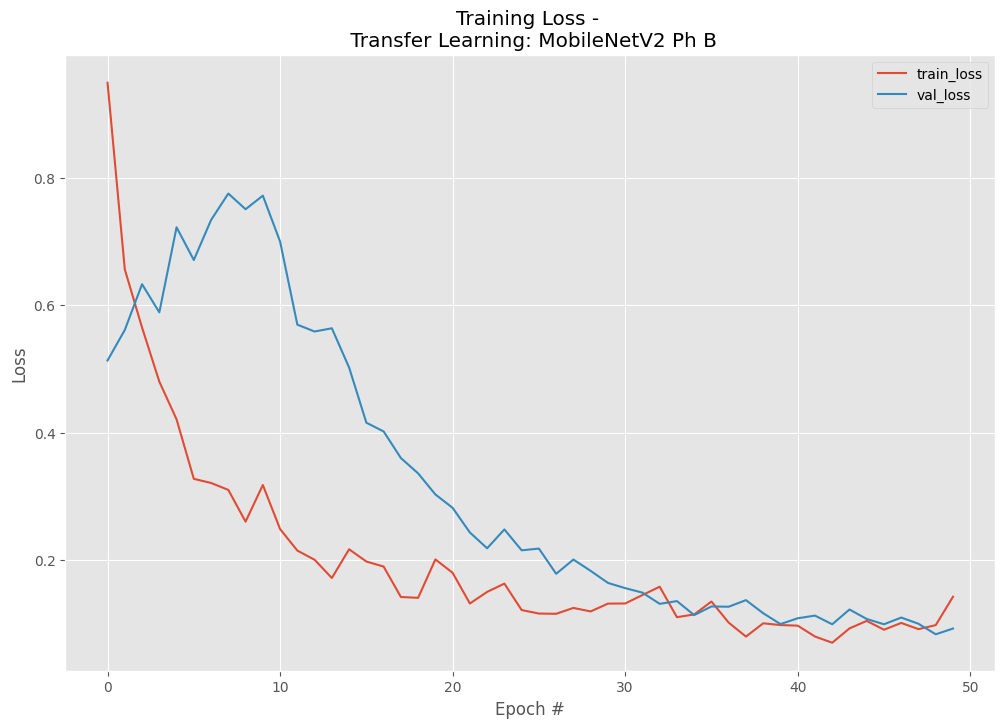

ACC:       0.9676089517078916
Precision: 0.9683095030259599
Recall:    0.9676089517078916
F1:        0.9677516823635147

Predicting test set classes.
Test set score: [0.09677712619304657, 0.9676089286804199]
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
Done


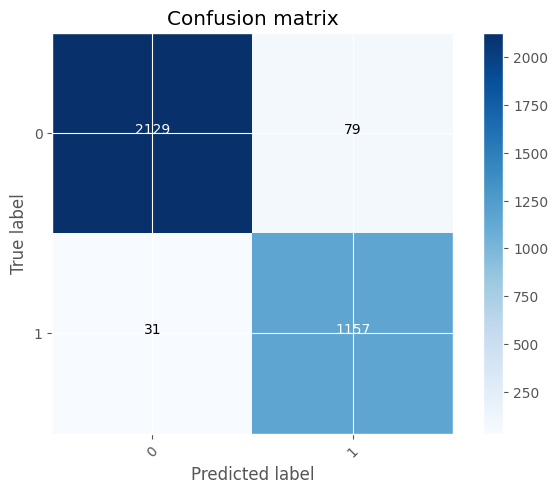

In [11]:
NET = 'MobileNetV2'

model1 = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model1.run()
################################################################################
model1.predict()
Y_pred = model1.predictions
Y_pred_classes = np.argmax(Y_pred,axis = 1)
confusion_mtx = confusion_matrix(np.argmax(model1.y_test, axis=1), Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [20]:
model1.saveModel('MobileNetV2.keras')

In [ ]:
with open('fitted_model.pickle', 'wb') as modelFile:
      pickle.dump(model1.model, modelFile)

In [ ]:
num = 32